In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip -q -o ravdess-emotional-speech-audio.zip -d ravdess
!find ravdess -maxdepth 3 -type d -name "Actor_*" | wc -l


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 97% 418M/429M [00:00<00:00, 430MB/s]
100% 429M/429M [00:00<00:00, 500MB/s]
48


In [3]:
import os, random, math, json
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_PATH = "ravdess/Actor_01-24"
if not os.path.exists(DATA_PATH):

    for root, dirs, files in os.walk("ravdess"):
        if any(d.startswith("Actor_") for d in dirs):
            DATA_PATH = root
            break

In [5]:
SAMPLE_RATE = 22050
DURATION = 3.0
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512


MAX_FRAMES = 130

In [6]:
EMOTION_MAP = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

In [7]:
def list_wav_files(base_path):
    wavs = []
    for root, _, files in os.walk(base_path):
        for f in files:
            if f.lower().endswith(".wav"):
                wavs.append(os.path.join(root, f))
    return sorted(wavs)

def parse_emotion_from_name(filename):
    code = os.path.basename(filename).split("-")[2]
    return EMOTION_MAP.get(code, "unknown")

def center_crop_signal(y, desired_len, sr=SAMPLE_RATE):
    """Center-crop or pad audio to desired_len samples."""
    target = int(desired_len)
    cur = len(y)
    if cur == target:
        return y
    if cur > target:
        start = (cur - target) // 2
        return y[start:start+target]
    # pad
    pad_left = (target - cur) // 2
    pad_right = target - cur - pad_left
    return np.pad(y, (pad_left, pad_right), mode='constant')

def extract_mfcc_sequence(wav_path, sr=SAMPLE_RATE, duration=DURATION, n_mfcc=N_MFCC,
                          n_fft=N_FFT, hop_length=HOP_LENGTH, max_frames=MAX_FRAMES):
    y, sr = librosa.load(wav_path, sr=sr)

    desired_samples = int(sr * duration)
    y = center_crop_signal(y, desired_samples, sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    T = mfcc.shape[1]
    if T < max_frames:
        pad = max_frames - T
        mfcc = np.pad(mfcc, ((0,0),(0,pad)), mode='constant')
    elif T > max_frames:
        mfcc = mfcc[:, :max_frames]


    return mfcc.T.astype(np.float32)

In [8]:
all_files = list_wav_files(DATA_PATH)
print(f"Found {len(all_files)} wav files under: {DATA_PATH}")

X_list, y_list, fp_list = [], [], []
for path in tqdm(all_files, desc="Extracting MFCC"):
    emotion = parse_emotion_from_name(path)
    if emotion == "unknown":
        continue
    X_list.append(extract_mfcc_sequence(path))
    y_list.append(emotion)
    fp_list.append(path)

X = np.stack(X_list, axis=0)
y_text = np.array(y_list)
filepaths = np.array(fp_list)
print("X shape:", X.shape, "y len:", len(y_text))

Found 2880 wav files under: ravdess


Extracting MFCC: 100%|██████████| 2880/2880 [00:52<00:00, 54.74it/s]


X shape: (2880, 130, 40) y len: 2880


In [10]:

encoder = LabelEncoder()
y_int = encoder.fit_transform(y_text)
num_classes = len(encoder.classes_)
print("Classes:", list(encoder.classes_))


X_train, X_test, y_train_int, y_test_int, fp_train, fp_test = train_test_split(
    X, y_int, filepaths, test_size=0.2, random_state=SEED, stratify=y_int
)


X_train, X_val, y_train_int, y_val_int, fp_train, fp_val = train_test_split(
    X_train, y_train_int, fp_train, test_size=0.1, random_state=SEED, stratify=y_train_int
)


y_train = tf.keras.utils.to_categorical(y_train_int, num_classes)
y_val   = tf.keras.utils.to_categorical(y_val_int,   num_classes)
y_test  = tf.keras.utils.to_categorical(y_test_int,  num_classes)

X_train.shape, X_val.shape, X_test.shape


Classes: [np.str_('angry'), np.str_('calm'), np.str_('disgust'), np.str_('fearful'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprised')]


((2073, 130, 40), (231, 130, 40), (576, 130, 40))

In [11]:
model = Sequential([
    Input(shape=(MAX_FRAMES, N_MFCC)),
    Masking(mask_value=0.0),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 130, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 130, 128)       │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 130, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,616 (549.28 KB)

 Trainable params: 140,616 (549.28 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_emotion_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.1580 - loss: 2.0547 - val_accuracy: 0.3247 - val_loss: 1.8041
Epoch 2/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2786 - loss: 1.8484 - val_accuracy: 0.3723 - val_loss: 1.6486
Epoch 3/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3458 - loss: 1.7006 - val_accuracy: 0.4372 - val_loss: 1.5136
Epoch 4/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3967 - loss: 1.6053 - val_accuracy: 0.4632 - val_loss: 1.4710
Epoch 5/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4426 - loss: 1.5252 - val_accuracy: 0.4978 - val_loss: 1.3354
Epoch 6/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4933 - loss: 1.3624 - val_accuracy: 0.5065 - val_loss: 1.3005
Epoch 7/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5158 - loss: 1.3020 - val_accuracy: 0.5584 - val_loss: 1.2269
Epoch 8/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5541 - loss: 1.2351 - val_accuracy: 0.5887 - v

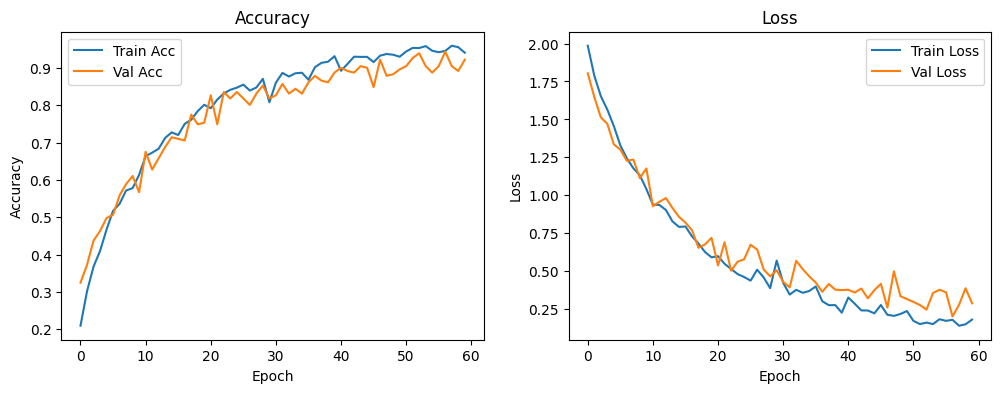

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.show()

Test Accuracy: 0.9184  |  Test Loss: 0.3448
              precision    recall  f1-score   support

       angry       0.99      0.89      0.94        76
        calm       0.99      0.90      0.94        77
     disgust       0.91      0.96      0.94        77
     fearful       0.90      0.95      0.92        77
       happy       0.92      0.88      0.90        77
     neutral       0.80      0.97      0.88        38
         sad       0.85      0.91      0.88        77
   surprised       0.96      0.91      0.93        77

    accuracy                           0.92       576
   macro avg       0.92      0.92      0.92       576
weighted avg       0.92      0.92      0.92       576



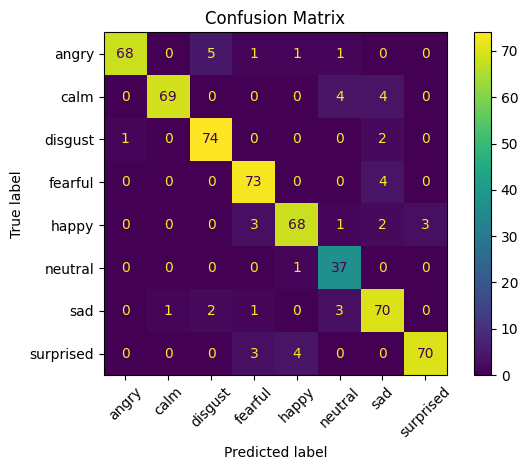

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}  |  Test Loss: {test_loss:.4f}")


y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


print(classification_report(y_true, y_pred, target_names=encoder.classes_))


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Random test sample:
File: ravdess/Actor_14/03-01-03-01-01-01-14.wav
True: happy | Pred: happy


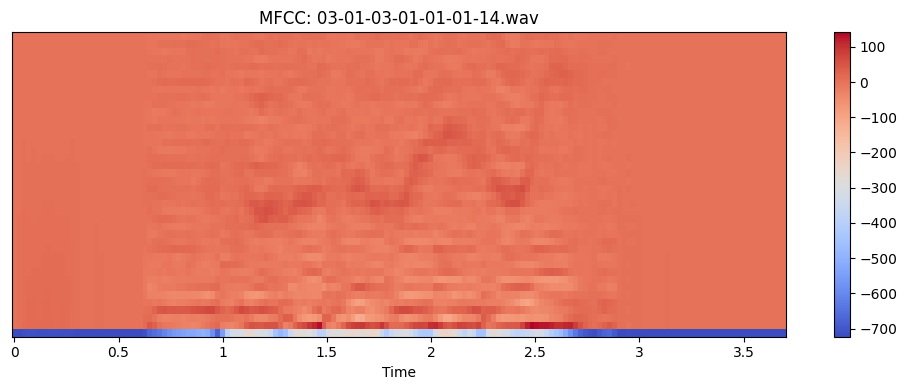

In [15]:
import IPython.display as ipd

idx = random.randrange(len(X_test))
sample = X_test[idx:idx+1]
true_label = encoder.inverse_transform([y_true[idx]])[0]
pred_label = encoder.inverse_transform([y_pred[idx]])[0]
sample_path = fp_test[idx]

print("Random test sample:")
print("File:", sample_path)
print("True:", true_label, "| Pred:", pred_label)

y_audio, sr_audio = librosa.load(sample_path, sr=SAMPLE_RATE)
ipd.display(ipd.Audio(y_audio, rate=sr_audio))

mfcc_for_plot = librosa.feature.mfcc(y=y_audio, sr=sr_audio, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_for_plot, x_axis='time', sr=sr_audio, hop_length=HOP_LENGTH)
plt.colorbar()
plt.title(f"MFCC: {os.path.basename(sample_path)}")
plt.tight_layout()
plt.show()
